In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# from fbprophet import Prophet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-stock-market-data-19802024/AAPL_historical_data.csv


In [16]:
# read in all our data

data = pd.read_csv("../input/apple-stock-market-data-19802024/AAPL_historical_data.csv")


# set seed for reproducibility
np.random.seed(0) 

In [17]:
data.head()

,Date,Open,High,Low,Close
0,1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834
1,1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678
2,1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802
3,1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951
4,1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530


In [18]:
# get the number of missing data points per column
missing_values_count = data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:-1]

Date    0
Open    0
High    0
Low     0
dtype: int64

In [19]:
# check accident data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11094 non-null  object 
 1   Open    11094 non-null  float64
 2   High    11094 non-null  float64
 3   Low     11094 non-null  float64
 4   Close   11094 non-null  float64
dtypes: float64(4), object(1)
memory usage: 433.5+ KB


In [20]:
data['date'] = data['Date'].apply(func=lambda x: str(x).split(sep=' ')[0])
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data.head()

,Date,Open,High,Low,Close,date,year
0,1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,1980-12-12,1980
1,1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,1980-12-15,1980
2,1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,1980-12-16,1980
3,1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,1980-12-17,1980
4,1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,1980-12-18,1980


In [21]:
# Summary Statistics
print(data[['Open', 'High', 'Low', 'Close']].describe())


               Open          High           Low         Close
count  11094.000000  11094.000000  11094.000000  11094.000000
mean      23.236654     23.484468     23.001626     23.254564
std       49.129620     49.645173     48.654514     49.178271
min        0.038245      0.038245      0.037815      0.037815
25%        0.242896      0.248067      0.237920      0.242953
50%        0.442782      0.451501      0.435876      0.444634
75%       18.083088     18.278464     17.904287     18.107803
max      247.960007    250.800003    246.259995    248.130005


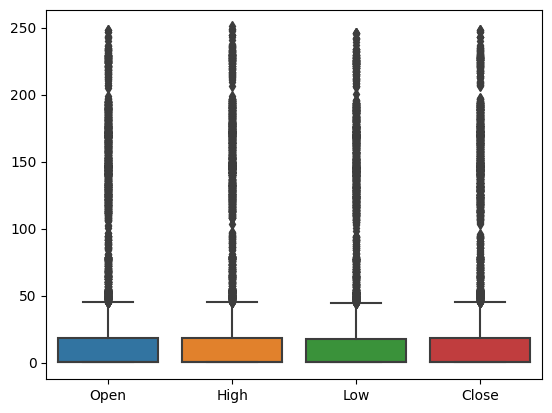

In [22]:
# Use boxplots for numerical columns:

sns.boxplot(data=data[['Open', 'High', 'Low', 'Close']])
plt.show()


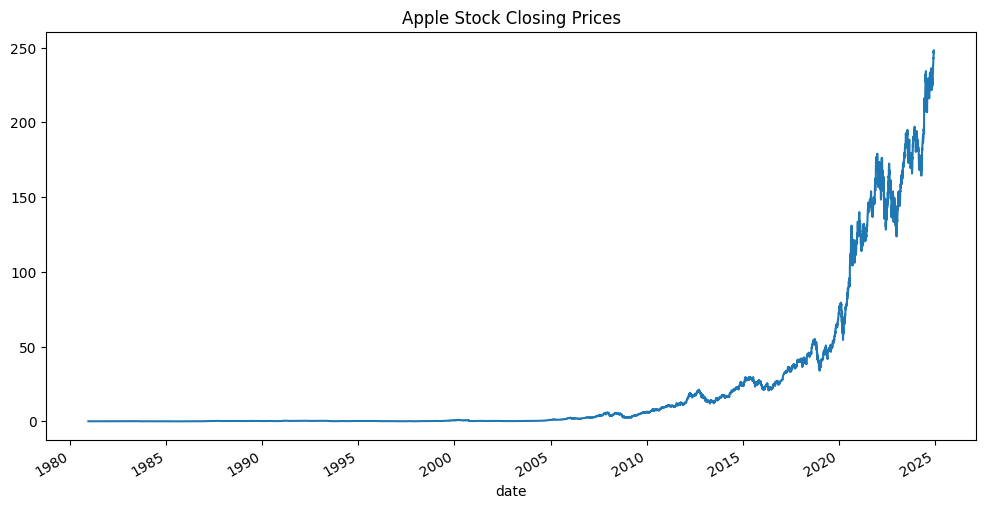

In [23]:
# Trends Over Time
data.set_index('date')['Close'].plot(figsize=(12, 6), title='Apple Stock Closing Prices')
plt.show()


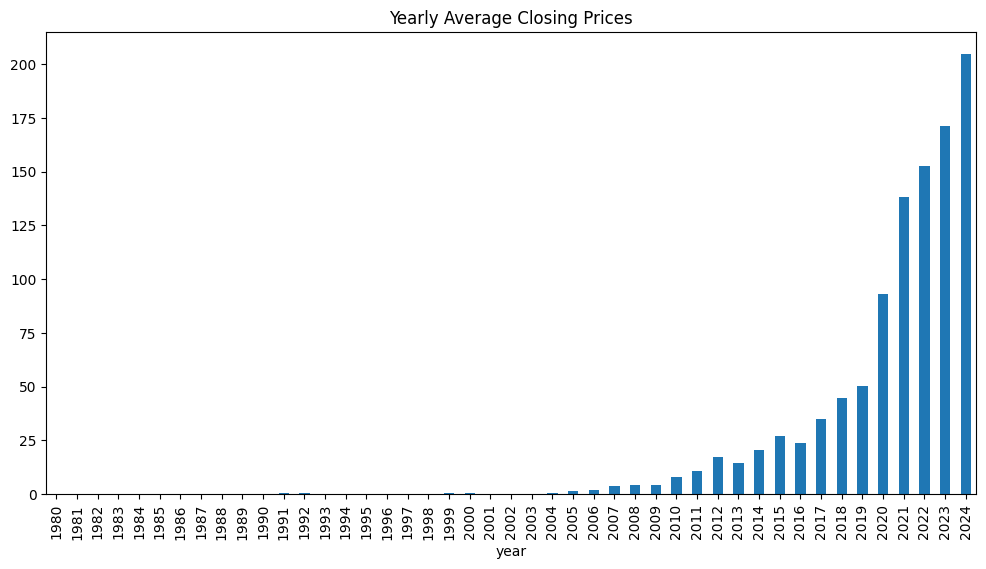

In [24]:
# Yearly Trends
yearly_trends = data.groupby('year')['Close'].mean()
yearly_trends.plot(kind='bar', figsize=(12, 6), title='Yearly Average Closing Prices')
plt.show()



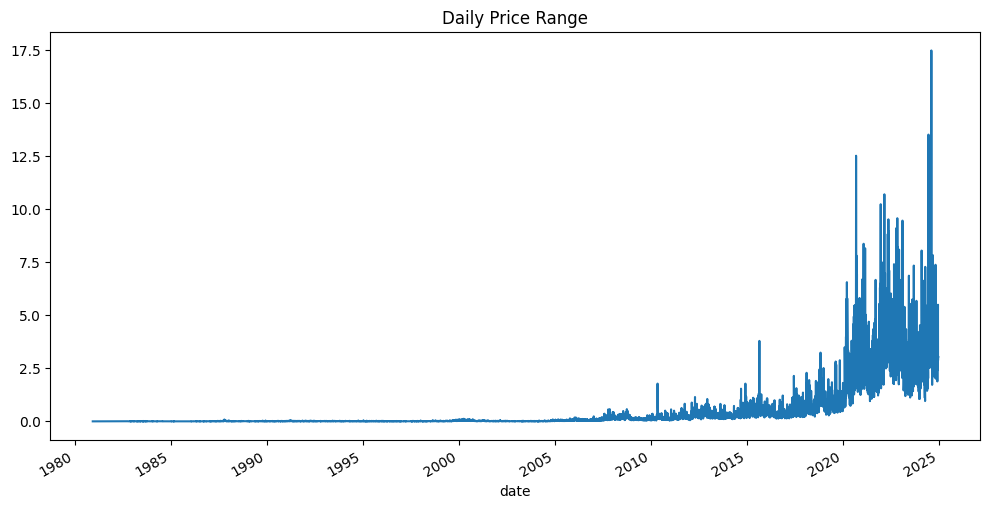

In [25]:
# Daily price range
data['Daily Range'] = data['High'] - data['Low']
data.set_index('date')['Daily Range'].plot(figsize=(12, 6), title='Daily Price Range')
plt.show()

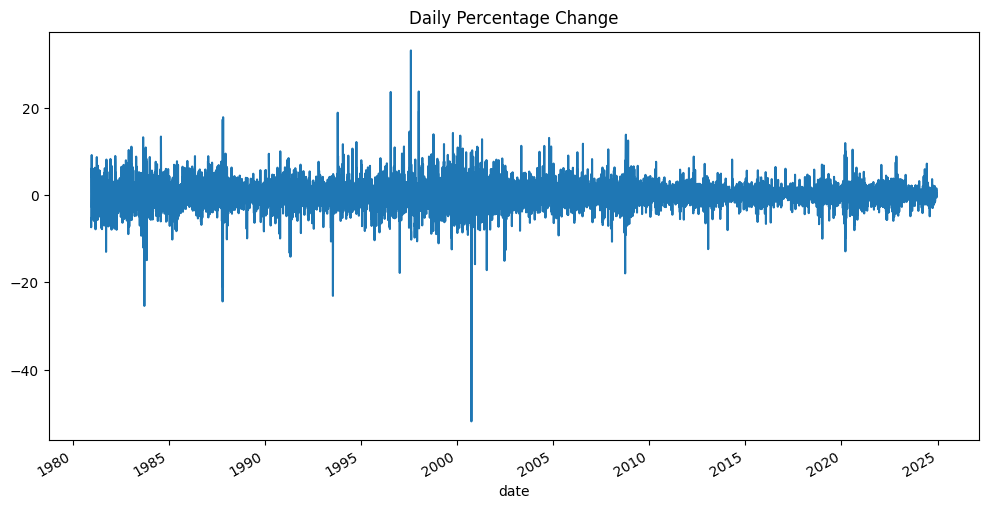

In [26]:
# Percentage change
data['Pct Change'] = data['Close'].pct_change() * 100
data.set_index('date')['Pct Change'].plot(figsize=(12, 6), title='Daily Percentage Change')
plt.show()


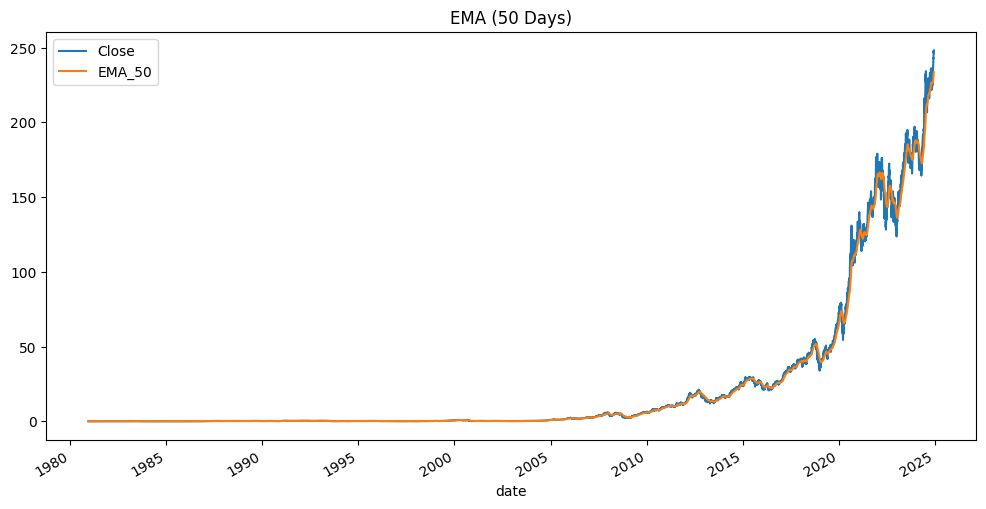

In [27]:

# Exponential Moving Average (EMA)
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data[['Close', 'EMA_50']].set_index(data['date']).plot(figsize=(12, 6), title='EMA (50 Days)')
plt.show()

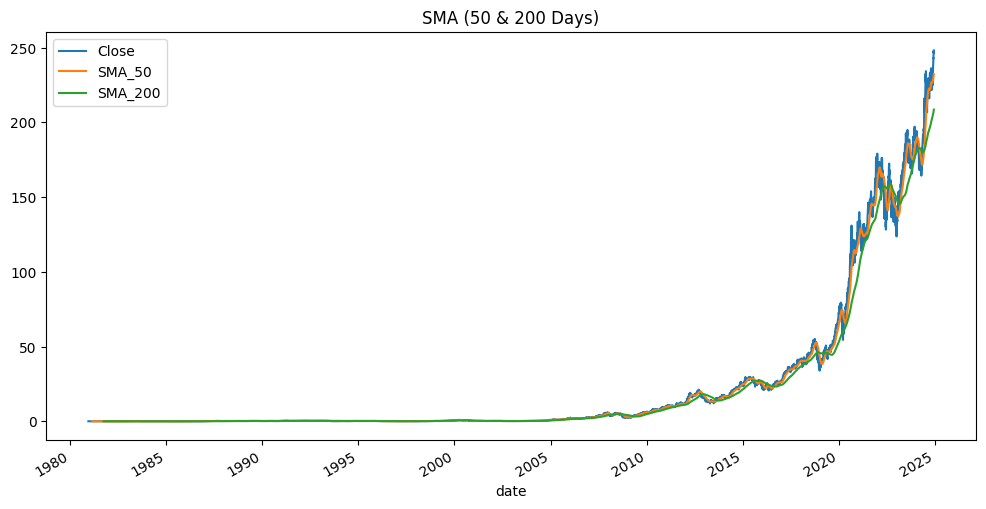

In [28]:

# Simple Moving Average (SMA)
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data[['Close', 'SMA_50', 'SMA_200']].set_index(data['date']).plot(figsize=(12, 6), title='SMA (50 & 200 Days)')
plt.show()

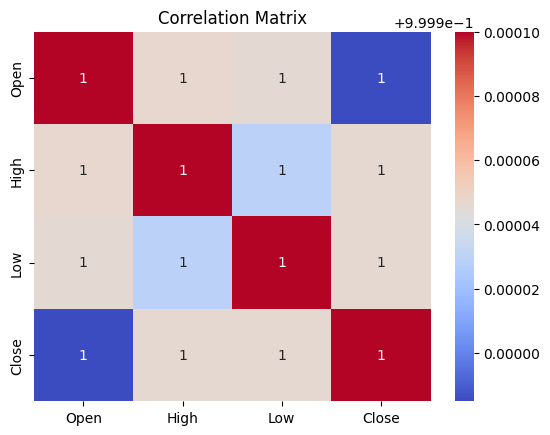

In [29]:

# Correlation matrix
correlation_matrix = data[['Open', 'High', 'Low', 'Close']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

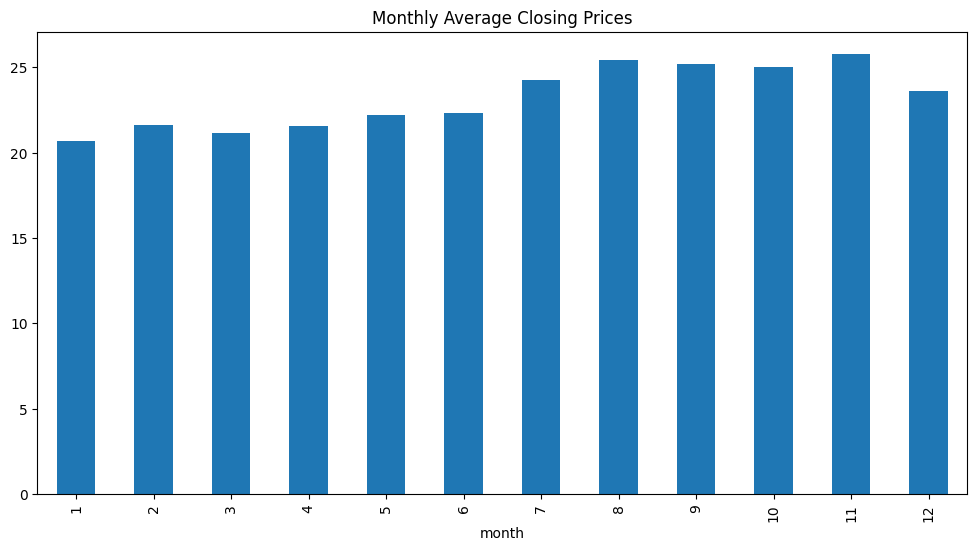

In [30]:

# Monthly trends
data['month'] = data['date'].dt.month
monthly_avg = data.groupby('month')['Close'].mean()
monthly_avg.plot(kind='bar', figsize=(12, 6), title='Monthly Average Closing Prices')
plt.show()

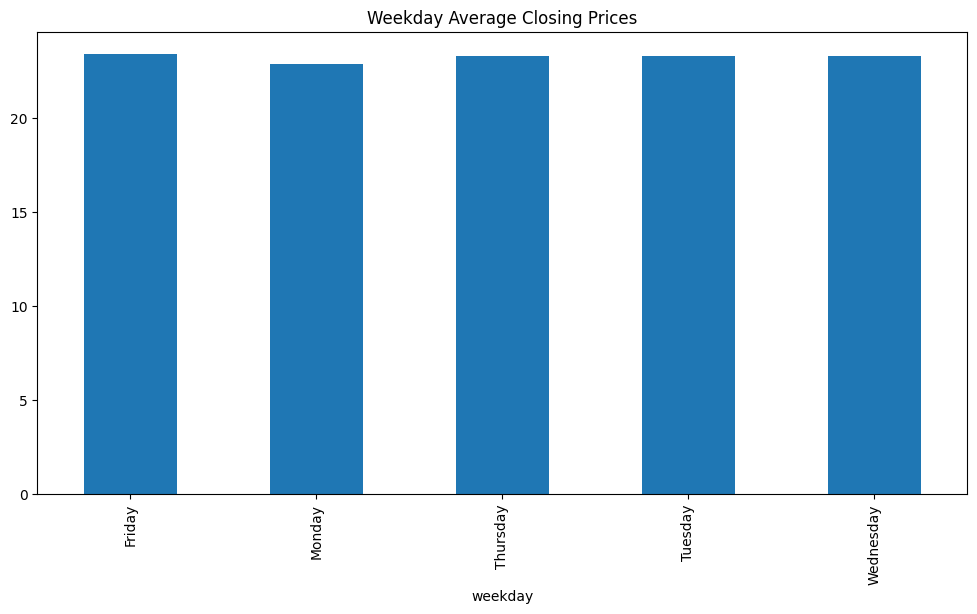

In [31]:
# Weekday trends:
data['weekday'] = data['date'].dt.day_name()
weekday_avg = data.groupby('weekday')['Close'].mean()
weekday_avg.plot(kind='bar', figsize=(12, 6), title='Weekday Average Closing Prices')
plt.show()

In [32]:
# Large price changes
significant_changes = data[abs(data['Pct Change']) > 5]
print(significant_changes[['date', 'Close', 'Pct Change']])

            date       Close  Pct Change
1     1980-12-15    0.093678   -5.217062
2     1980-12-16    0.086802   -7.339819
5     1980-12-19    0.097116    6.102832
8     1980-12-24    0.111726    5.262790
9     1980-12-26    0.122039    9.230923
...          ...         ...         ...
10526 2022-09-13  151.986938   -5.867957
10559 2022-10-28  153.864075    7.555262
10568 2022-11-10  145.341599    8.897457
10938 2024-05-03  182.718857    5.981621
10964 2024-06-11  206.683105    7.264916

[751 rows x 3 columns]


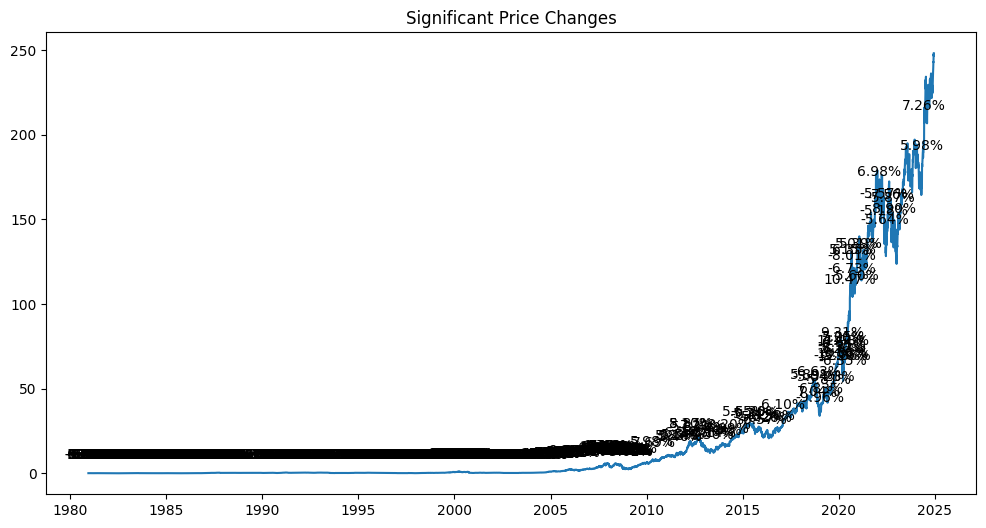

In [33]:
# Annotate significant events
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['date'], data['Close'], label='Close Price')
for idx, row in significant_changes.iterrows():
    ax.annotate(f"{row['Pct Change']:.2f}%", (row['date'], row['Close']), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Significant Price Changes')
plt.show()

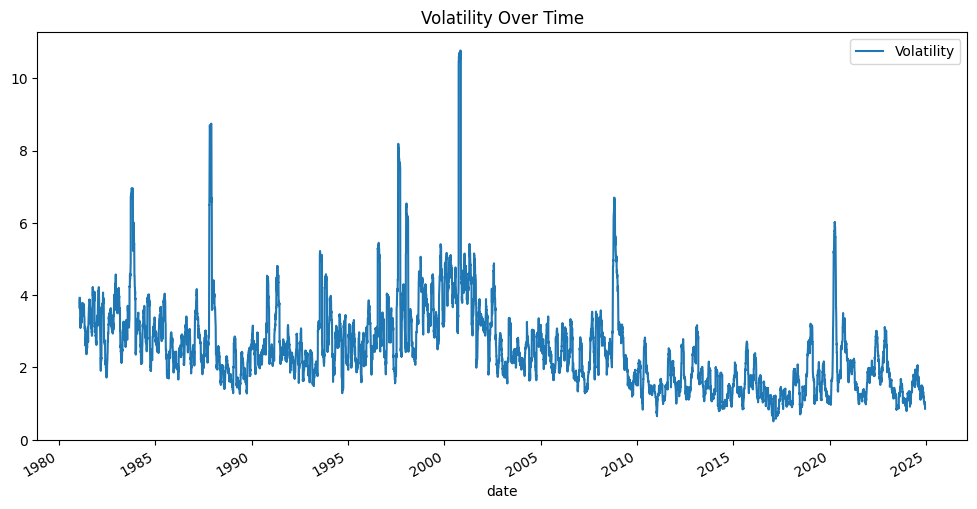

In [34]:
# Volatility clustering:
data['Volatility'] = data['Pct Change'].rolling(window=30).std()
data[['Volatility']].set_index(data['date']).plot(figsize=(12, 6), title='Volatility Over Time')
plt.show()

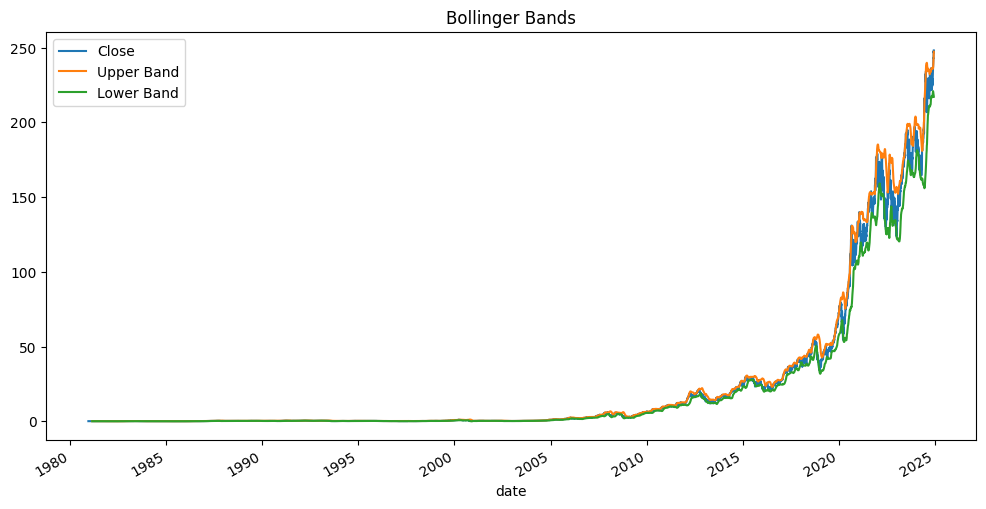

In [35]:
# Bollinger Bands:
data['Upper Band'] = data['SMA_50'] + 2 * data['Close'].rolling(window=50).std()
data['Lower Band'] = data['SMA_50'] - 2 * data['Close'].rolling(window=50).std()
data[['Close', 'Upper Band', 'Lower Band']].set_index(data['date']).plot(figsize=(12, 6), title='Bollinger Bands')
plt.show()


In [36]:
 # Prepare the Data for Forecasting

In [55]:
# Focus on the Close price for forecasting
closing_prices = data['Close']

In [56]:
# Check Stationarity
# ARIMA requires the data to be stationary.

# Perform the Augmented Dickey-Fuller (ADF) test:

result = adfuller(closing_prices)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: 4.834757419070473
p-value: 1.0


In [58]:
# Apply differencing if necessary:
diff = closing_prices.diff().dropna()

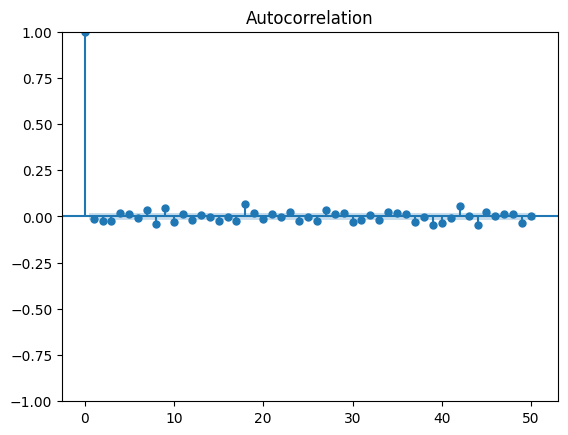

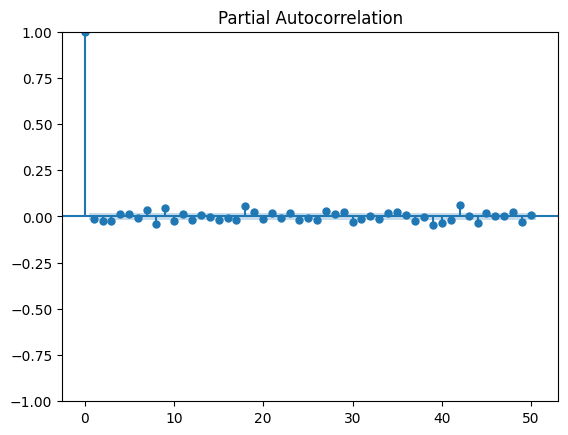

In [59]:
# Use Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) plots.

plot_acf(diff, lags=50)
plot_pacf(diff, lags=50)
plt.show()


In [60]:
# Fit the ARIMA Model
# Select parameters (p, d, q) based on the ACF/PACF plots

model = ARIMA(closing_prices, order=(p, d, q))
arima_result = model.fit()
print(arima_result.summary())


NameError: name 'p' is not defined

In [61]:
# Make Predictions
# Forecast future values:

forecast = arima_result.forecast(steps=30)  # Forecast for 30 days
print(forecast)


NameError: name 'arima_result' is not defined

NameError: name 'forecast' is not defined

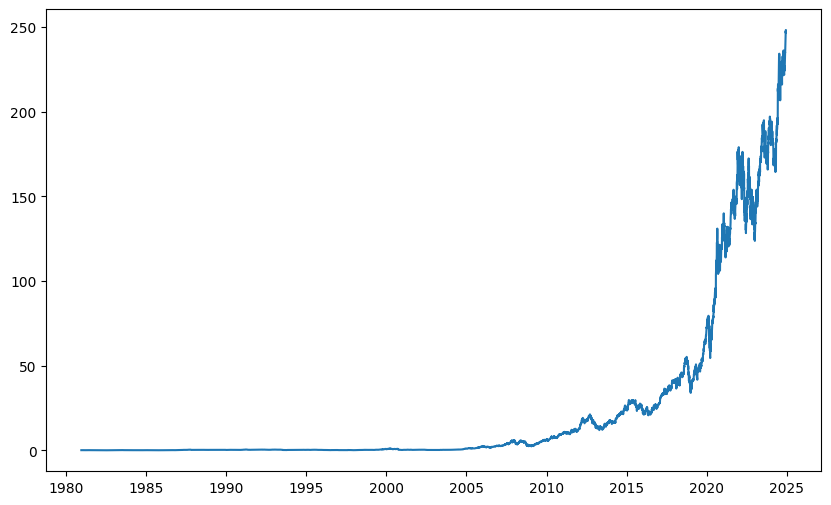

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(closing_prices, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()


In [ ]:
# Forecasting Using LSTM (Deep Learning)
# Prepare the Data
# Normalize and convert the data into sequences.

# Scale the data:

In [62]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(closing_prices.values.reshape(-1, 1))


In [51]:
sequence_length = 50  # Use the last 50 days to predict the next day
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input


In [52]:
# Build and Train the Model
# Define the LSTM model:

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0041
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 6.5074e-04
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 5.1535e-04
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 4.4824e-04
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 4.0427e-04
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 4.0777e-04
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 4.0901e-04
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 3.4186e-04
Epoch 9/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 3.4021e-04
Epoch 10/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 3.7732e-04


In [63]:
# Make Predictions
# Predict future prices:


test_data = scaled_data[-sequence_length:]  # Use the last 50 days
test_data = np.reshape(test_data, (1, test_data.shape[0], 1))
prediction = model.predict(test_data)
prediction = scaler.inverse_transform(prediction)  # Scale back to original range
print("Predicted Price:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
Predicted Price: [[235.79332]]


In [ ]:
# Forecasting Using Prophet
# Prepare the Data
# Convert the data into a format suitable for Prophet.

In [ ]:

prophet_data = closing_prices.reset_index()
prophet_data.columns = ['ds', 'y']  # Rename columns for Prophet


In [ ]:
model = Prophet()
model.fit(prophet_data)


In [ ]:
future = model.make_future_dataframe(periods=30)  # Forecast 30 days into the future
forecast = model.predict(future)


In [ ]:
model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()
